In [1]:
from concepts import Context as BaseContext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
class Context(BaseContext):
    def __init__(self, objetos, atributos, bools, confianza=0.85, soporte=32/712):
        super().__init__(objetos, atributos, bools)
        self.confianza = confianza
        self.soporte = soporte
        self.base_stem = None
        self.base_luxenburger = None
        self.base_completa = None

    @classmethod
    def desde_dataframe(cls, df, confianza=0.85, soporte=32/712):
        # Eliminar la primera columna del dataframe df que corresponde al id
        df = df.iloc[:, 1:]
        objetos = list(df.index.astype(str))
        atributos = list(df.columns.astype(str))
        bools = [tuple(bool(x) for x in fila) for fila in df.values]
        return cls(objetos, atributos, bools, confianza, soporte)


    def set_confianza(self, confianza):
        """Establece el valor del hiperparámetro confianza."""
        self.confianza = confianza

    def get_confianza(self):
        """Obtiene el valor del hiperparámetro confianza."""
        return self.confianza

    def set_soporte(self, soporte):
        """Establece el valor del hiperparámetro soporte."""
        self.soporte = soporte

    def get_soporte(self):
        """Obtiene el valor del hiperparámetro soporte."""
        return self.soporte
    
    def cerrar(self, conj, impls):
        """Cierra un conjunto de atributos usando la base de implicaciones de entrada."""
        cerrado = set(conj)
        cambios = True
        while cambios:
            cambios = False
            for impl,_,_ in impls:
                if impl[0].issubset(cerrado) and not impl[1].issubset(cerrado):
                    cerrado.update(impl[1])
                    cambios = True
        return cerrado

    def next_closure(self, conjunto, conj_impls):
        """Calcula el siguiente cierre de un conjunto de atributos."""
        rev_set_prop=sorted(self.properties, reverse=True)
        for atributo in rev_set_prop:
            if atributo in conjunto:
                conjunto=conjunto - {atributo}
            else:
                sig_conj_cerrado=self.cerrar(conjunto | {atributo}, conj_impls)
                if all(x >= atributo for x in sig_conj_cerrado - conjunto):
                    return sig_conj_cerrado
        return None
    
    def doble_derivada(self, conjunto):
        """Calcula la doble derivada de un conjunto de atributos."""
        conjunto2 = set(conjunto)
        return set(self.intension(self.extension(conjunto2)))

    def calcular_base_stem(self):
        """Calcula la base Stem de un contexto como lista de tuplas."""
        conj_atrib=set()
        base=[]
        atributos=set(self.properties)
        while conj_atrib!=atributos and conj_atrib!= None:
            conj_atrib_pp=self.doble_derivada(conj_atrib)
            if conj_atrib != conj_atrib_pp:
                implicacion = (conj_atrib, conj_atrib_pp - conj_atrib)
                base.append((implicacion, 1., self.soporte_implicacion(implicacion)))
            conj_atrib = self.next_closure(conj_atrib, base)
        self.base_stem = base
        return base

    def es_cerrado(self, conjunto):
        """Determina si un conjunto de atributos es cerrado en un contexto formal."""
        return conjunto == set(self.intension(self.extension(conjunto)))

    def soporte_atributos(self, conjunto):
        """Calcula el soporte de un conjunto de atributos en un contexto formal."""
        numerador = len(self.extension(conjunto))  # |A'|
        denominador = len(self.objects)  # |O|
        return numerador / denominador

    def soporte_concepto(self, concepto):
        """Calcula el soporte de un concepto en un contexto formal."""
        extension, _ = concepto
        numerador = len(extension)
        denominador = len(self.objects)
        return numerador / denominador

    def sigma_frecuente(self, concepto, sigma):
        """Determina si un concepto es frecuente en un contexto formal."""
        return self.soporte_concepto(concepto) >= sigma

    def es_inmediatamente_inferior(self, Y1, Y2):
        """Determina, por medio de sus conjuntos de atributos, si un concepto es inmediatamente inferior a otro en un contexto formal."""
        if Y1 == Y2:  # Si los conjuntos de atributos son iguales, no son inmediatamente inferiores
            return False
        if not Y1.issubset(Y2):  # Si Y1 no es subconjunto de Y2, no son inmediatamente inferiores
            return False
        if not self.es_cerrado(Y1) or not self.es_cerrado(Y2):  # Si alguno de los conjuntos de atributos no es cerrado, no son inmediatamente inferiores
            return False
        extension1 = self.extension(Y1)
        extension2 = self.extension(Y2)
        vecinos = [(set(extension), set(intension)) for extension, intension in self.neighbors(extension2)]
        conceptoY1 = (set(extension1), Y1)
        if conceptoY1 in vecinos:  # Si el concepto (A', Y1) está en los vecinos de (A'', Y2), entonces Y1 es inmediatamente inferior a Y2
            return True
        else:
            return False

    def soporte_implicacion(self, implicacion):
        """Calcula el soporte de una implicación en un contexto formal."""
        antecedente, consecuente = implicacion
        numerador = len(self.extension(antecedente | consecuente))  # |(Y1 ∪ Y2)'|
        denominador = len(self.objects)  # |O|
        return numerador / denominador

    def confianza_implicacion(self, implicacion):
        """Calcula la confianza de una implicación en un contexto formal."""
        antecedente, consecuente = implicacion
        numerador = len(self.extension(antecedente | consecuente))  # |(Y1 ∪ Y2)'|
        denominador = len(self.extension(antecedente))  # |Y1'|
        if denominador == 0:
            return 1.0
        return numerador / denominador

    def calcular_base_luxenburger(self):
        """Calcula la base de Luxenburger de un contexto formal como lista de tuplas de conjuntos de atributos."""
        base_luxenburger = []
        visitados = set()
        reticulo = self.lattice
        n = len(self.objects)
        def aux_base_luxenburger(concepto_actual):
            """Auxiliar para recorrer cada nodo del reticulo del contexto formal de arriba a abajo."""
            if concepto_actual in visitados: # Si el concepto actual ya fue visitado, no hacer nada
                return
            visitados.add(concepto_actual)
            for vecino in concepto_actual.lower_neighbors: # Recorrer los vecinos inferiores del concepto actual
                intencion_vecino = set(vecino.intent)
                intencion_actual = set(concepto_actual.intent)
                implicacion = (intencion_actual, intencion_vecino - intencion_actual) # Representa la implicacion Act -> Vec\Act
                num_objetos_actual = len(concepto_actual.extent)
                if num_objetos_actual != 0:
                    conf_Implicacion = len(vecino.extent)/num_objetos_actual
                else:
                    conf_Implicacion = 0.
                sop_Implicacion = len(vecino.extent)/n
                if sop_Implicacion >= self.soporte and conf_Implicacion >= self.confianza: # Si la implicacion es frecuente, agregarla a la base de Luxenburger
                    base_luxenburger.append((implicacion, conf_Implicacion, sop_Implicacion))
                elif sop_Implicacion < self.soporte: # Realizar la poda si el soporte es menor al umbral
                    return
                aux_base_luxenburger(vecino)
        aux_base_luxenburger(reticulo[len(reticulo)-1]) # Comenzar desde el concepto superior del reticulo
        self.base_luxenburger = base_luxenburger
        return base_luxenburger
    
    def calcular_base_completa(self):
        """Calcula la base completa como la union de la base Stem y de Luxenburger."""
        if self.base_stem is None:
            raise Exception("Primero debe calcular la base Stem.")
        if self.base_luxenburger is None:
            raise Exception("Primero debe calcular la base de Luxenburger.")

        base_completa = self.base_stem.copy()
        base_completa.extend(self.base_luxenburger)
        self.base_completa = base_completa
        return base_completa
    
    def cerrar_conjunto(self, conjunto):
        """Dado un conjunto de atributos y la base de implicaciones, devuelve el conjunto cerrado."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        cerrado = set(conjunto)
        cambios = True
        while cambios:
            cambios = False
            for implicacion,_,_ in self.base_completa:
                if implicacion[0].issubset(cerrado) and not implicacion[1].issubset(cerrado):
                    cerrado.update(implicacion[1])
                    cambios = True
        return cerrado
    
    def entrenar(self):
        """Calcula todas las bases de un contexto formal."""
        self.calcular_base_stem()
        self.calcular_base_luxenburger()
        self.calcular_base_completa()
    
    def predecir(self, datos):
        """Predice las etiquetas de un dataframe de Xs y vacios aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        etiquetas = []
        datos.drop(columns=["Survived"], inplace=True, errors='ignore')
        for i in range(len(datos)):
            instancia = datos.iloc[i]
            conjunto = set(datos.columns[1:][instancia.iloc[1:] == "X"])
            cerrado = self.cerrar_conjunto(conjunto)
            if "Survived" in cerrado:
                etiquetas.append("X")
            else:
                etiquetas.append("")
        return pd.Series(etiquetas, index=datos.index, name="Survived")
    
    def precision(self, datos, etiquetas):
        """Calcula la precisión de un dataframe de Xs y vacios con sus etiquetas aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base de Luxenburger.")
        predicciones = self.predecir(datos)
        coincidencias = predicciones == etiquetas
        return coincidencias.mean()
    
    def falsos_positivos(self, datos, etiquetas):
        """Calcula la cantidad de falsos positivos de un dataframe de datos con sus etiquetas aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        predicciones = self.predecir(datos)
        falsos_positivos = ((predicciones == "X") & (etiquetas == "")).sum()
        return falsos_positivos
    
    def falsos_negativos(self, datos, etiquetas):
        """Calcula la cantidad de falsos negativos de un dataframe de datos con sus etiquetas aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        predicciones = self.predecir(datos)
        falsos_negativos = ((predicciones == "") & (etiquetas == "X")).sum()
        return falsos_negativos
    
    def calcula_resultados(self, datos, etiquetas):
        """Calcula la precisión, falsos positivos y falsos negativos de un dataframe de datos con sus etiquetas aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        predicciones = self.predecir(datos)
        coincidencias = predicciones == etiquetas
        falsos_positivos = ((predicciones == "X") & (etiquetas == "")).sum()
        falsos_negativos = ((predicciones == "") & (etiquetas == "X")).sum()
        return coincidencias.mean(), falsos_positivos, falsos_negativos

In [4]:
# Cargar el dataset del Titanic
data = pd.read_csv("train.csv")
print(data.head())
print(type(data))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

Valores únicos de Pclass: [3 1 2]
Valores únicos de Age: [22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.  ]
Valores únicos de SibSp: [1 0 3 4 2 5 8]
Valores únicos de Parch: [0 1 2 5 3 4 6]
Valores únicos de Embarked: ['S' 'C' 'Q' nan]
512.3292


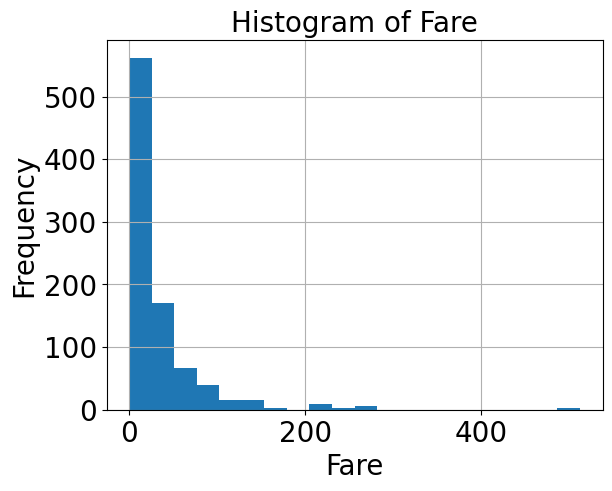

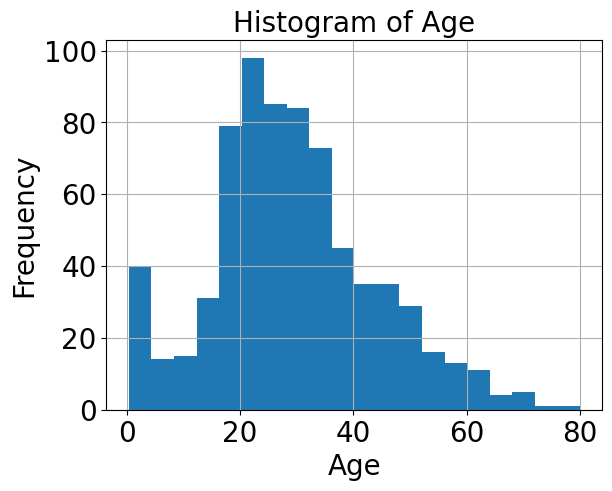

In [5]:
# Mostrar los valores únicos de las columnas Pclass, Age, SibSp, Parch, Embarked
print("Valores únicos de Pclass:", data['Pclass'].unique())
print("Valores únicos de Age:", data['Age'].unique())
print("Valores únicos de SibSp:", data['SibSp'].unique())
print("Valores únicos de Parch:", data['Parch'].unique())
print("Valores únicos de Embarked:", data['Embarked'].unique())

print(data['Fare'].max())

plt.rcParams.update({
    'font.size': 20,        # Tamaño general
    'axes.titlesize': 20,   # Título del gráfico
    'axes.labelsize': 20,   # Etiquetas de ejes
    'xtick.labelsize': 20,  # Tamaño de los números del eje X
    'ytick.labelsize': 20,  # Tamaño de los números del eje Y
})

# Crear un histograma para la columna Fare con 10 intervalos
data['Fare'].hist(bins=20)
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Histogram of Fare')
plt.show()

data['Age'].hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')
plt.show()

In [6]:
# Reemplazar valores nulos con el valor más frecuente
data.loc[:, 'Sex'] = data['Sex'].fillna(data['Sex'].mode()[0])
data.loc[:, 'Age'] = data['Age'].fillna(data['Age'].median())
data.loc[:, 'Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data.loc[:, 'Pclass'] = data['Pclass'].fillna(data['Pclass'].mode()[0])
data.loc[:, 'Fare'] = data['Fare'].fillna(data['Fare'].mean())
data.loc[:, 'SibSp'] = data['SibSp'].fillna(data['SibSp'].mode()[0])
data.loc[:, 'Parch'] = data['Parch'].fillna(data['Parch'].mode()[0])

separacion_age = 4
separacion_fare = 8    

# Definir intervalos y etiquetas de edad
age_bins = [i/separacion_age*81 for i in range(separacion_age+1)]
age_labels = [f"{int(age_bins[i])}-{int(age_bins[i+1])}" for i in range(len(age_bins)-1)]
# Crear una nueva columna con categorías de edad
data["AgeGroup"] = pd.cut(data["Age"], bins=age_bins, labels=age_labels, right=False)

# Definir intervalos y etiquetas de tarifa
fare_bins = [i/separacion_fare*513 for i in range(separacion_fare+1)]
fare_labels = [f"{int(fare_bins[i])}-{int(fare_bins[i+1])}" for i in range(len(fare_bins)-1)]

# Crear una nueva columna con categorías de tarifa
data["FareGroup"] = pd.cut(data["Fare"], bins=fare_bins, labels=fare_labels, right=False)

# Definir intervalos y etiquetas de SibSp
sibsp_bins = [0, 1, 3, 5, 7, float('inf')]
sibsp_labels = ["0-1", "1-3", "3-5", "5-7", "7+"]

# Crear una nueva columna con categorías de SibSp
data["SibSpGroup"] = pd.cut(data["SibSp"], bins=sibsp_bins, labels=sibsp_labels, right=False)

# Definir intervalos y etiquetas de Parch
parch_bins = [0, 1, 3, 5,float('inf')]
parch_labels = ["0-1", "1-3", "3-5", "5+"]

# Crear una nueva columna con categorías de Parch
data["ParchGroup"] = pd.cut(data["Parch"], bins=parch_bins, labels=parch_labels, right=False)

# Convertir a codificación one-hot (columnas 1/0)
data = pd.get_dummies(data, columns=["FareGroup", "AgeGroup", "Embarked", "Pclass", "SibSpGroup", "ParchGroup"], dtype=int, drop_first=False)

# Convertir columnas a 1/0
data['Male'] = data['Sex'].map({'male': 1, 'female': 0})
data['Female'] = data['Sex'].map({'male': 0, 'female': 1})

# Añadir una columna que sea la contraria de la columna 'Survived'
#data['NotSurvived'] = data['Survived'].map({0: 1, 1: 0})

# Eliminar las columnas inútiles
data.drop(['Age', 'Sex', 'Fare', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1, inplace=True)

# Convertir selectivamente columnas a tipo string antes de reemplazar 1 con 'X'
columns_to_convert = data.columns[1:]
data[columns_to_convert] = data[columns_to_convert].astype(str).map(lambda x: 'X' if x == '1' else '')

# Mostrar los nombres de las columnas
#print("Nombres de las columnas:", data.columns)

# Guardar el resultado final en un archivo CSV
data.to_csv("trainDummy.csv", index=False)

In [7]:
# Separar el dataset en 80% train y 20% test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=40, stratify=data['Survived'])

# Guardar los datasets de entrenamiento y prueba en archivos CSV
train_data.to_csv("train_data_variado.csv", index=False)
test_data.to_csv("test_data_variado.csv", index=False)

# Mostrar las primeras filas del dataset de entrenamiento
print("Train Data:")
#print(train_data.head())
print(len(train_data))
# Mostrar las primeras filas del dataset de prueba
print("Test Data:")
#print(test_data.head())
print(len(test_data))
#print(test_data.columns)

Train Data:
712
Test Data:
179


In [8]:
# Cargar el dataset de prueba
test_data = pd.read_csv('test_data_variado.csv').fillna('') # Rellenar valores nulos con cadena vacía
etiquetas = test_data['Survived']
datos = test_data.drop(columns=['Survived'])
print(f"Número de datos de prueba: {len(datos)}")

Número de datos de prueba: 179


In [9]:
context=Context.fromfile('train_data_variado.csv', frmat='csv')

In [10]:
# Aquí se han calculado los histogramas para las diferentes confianzas y soportes de las implicaciones de las bases
context.set_confianza(0)
context.set_soporte(0)

context.calcular_base_stem()
#context.base_stem = []
context.calcular_base_luxenburger()
#context.base_luxenburger = []
base_completa=context.calcular_base_completa()

print(len(context.base_completa))
soportes=[t[2] for t in context.base_completa]
confianzas=[t[1] for t in context.base_completa]

plt.rcParams.update({
    'font.size': 20,        # Tamaño general
    'axes.titlesize': 20,   # Título del gráfico
    'axes.labelsize': 20,   # Etiquetas de ejes
    'xtick.labelsize': 20,  # Tamaño de los números del eje X
    'ytick.labelsize': 20,  # Tamaño de los números del eje Y
    'legend.fontsize': 16,        # Tamaño del texto de la leyenda
    'legend.title_fontsize': 20, 
    })

plt.hist(soportes, bins=40, edgecolor='black', color='blue', alpha=0.7)
plt.xlabel('Soporte')
plt.ylabel('Frecuencia')
plt.title('Histograma del soporte de la base completa')
plt.grid(True)
plt.show()

plt.hist(confianzas, bins=40, edgecolor='black', color='green', alpha=0.7)
plt.xlabel('Confianza')
plt.ylabel('Frecuencia')
plt.title('Histograma de la confianza de la base completa')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
# Listas para almacenar los datos
resultados_csv = []
#confianzas = [0, 0.2, 0.5, 0.8, 0.9, 0.95]
#soportes = [0.0, 1/712, 2/712, 8/712, 32/712, 128/712]
confianzas = [0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85]
soportes = [4/712, 5/712, 6/712, 7/712, 8/712, 9/712, 10/712, 11/712, 12/712, 13/712]
#context.calcular_base_stem()
for conf in confianzas:
    for sop in soportes:
        context.set_confianza(conf)
        context.set_soporte(sop)
        context.calcular_base_luxenburger()
        context.calcular_base_completa()
        context.base_completa = [i for i in context.base_completa if i[2] >= sop and 'Survived' not in i[0][0] and 'Survived' in i[0][1]]
        resultados = context.calcula_resultados(datos, etiquetas)

        antecedente = sum(1 for t in context.base_completa if "Survived" in t[0][0])
        consecuente = sum(1 for t in context.base_completa if "Survived" in t[0][1])

        resultados_csv.append({
            "Confianza": round(conf, 2),
            "Soporte": round(sop, 3),
            "R. acierto": round(resultados[0], 3),
            "FP": resultados[1],
            "FN": resultados[2],
            "Total": len(context.base_completa),
        })

# Crear DataFrame y guardar en CSV
df = pd.DataFrame(resultados_csv)
df.to_csv("resultados_luxenburger.csv", index=False)

# Mostrar tabla
print(df)

(np.float64(0.7877094972067039), np.int64(26), np.int64(12))
(np.float64(0.7877094972067039), np.int64(25), np.int64(13))
(np.float64(0.7932960893854749), np.int64(24), np.int64(13))
(np.float64(0.8044692737430168), np.int64(22), np.int64(13))
(np.float64(0.8156424581005587), np.int64(20), np.int64(13))
(np.float64(0.8212290502793296), np.int64(19), np.int64(13))
(np.float64(0.8212290502793296), np.int64(19), np.int64(13))
(np.float64(0.8212290502793296), np.int64(19), np.int64(13))
(np.float64(0.8156424581005587), np.int64(19), np.int64(14))
(np.float64(0.8156424581005587), np.int64(19), np.int64(14))
(np.float64(0.8100558659217877), np.int64(22), np.int64(12))
(np.float64(0.8100558659217877), np.int64(21), np.int64(13))
(np.float64(0.8156424581005587), np.int64(20), np.int64(13))
(np.float64(0.8156424581005587), np.int64(20), np.int64(13))
(np.float64(0.8268156424581006), np.int64(18), np.int64(13))
(np.float64(0.8324022346368715), np.int64(17), np.int64(13))
(np.float64(0.8324022346

KeyboardInterrupt: 

In [ ]:
# Código para capítulo 6

#context.set_confianza(0.80)
#context.set_soporte(16/712)
#context.calcular_base_stem()
#context.calcular_base_luxenburger()
#context.calcular_base_completa()
# Aplicamos filtrado del capitulo 5
context.base_completa = [i for i in context.base_completa if i[2] >= 16/712 and 'Survived' not in i[0][0] and 'Survived' in i[0][1]]
resultados = context.calcula_resultados(datos, etiquetas)
print(resultados)


(np.float64(0.8435754189944135), np.int64(13), np.int64(15))


Código del capítulo 6 de XAI

In [ ]:
def implicacion_activadora(contexto, dato):
    """Calcula la implicación que otorga el atributo Survived a un dato por medio del cierre implicacional."""
    conjunto = set(datos.columns[1:][dato.iloc[1:] == "X"])
    implicaciones = []
    for implicacion, confianza, _ in contexto.base_completa:
        if implicacion[0].issubset(conjunto):
            implicaciones.append((implicacion, confianza))
    return max(implicaciones, key=lambda x: x[1], default=(set(), 0))
    

In [ ]:
# Verdaderos positivos

# Filtro para obtener las instancias de verdaderos positivos
predicciones = context.predecir(datos)
print(predicciones)
res_VP = []
for i in range(len(predicciones)):
    if predicciones[i] == "X" and etiquetas[i] == "X":
        res_VP.append(datos.iloc[i])

res_VP = pd.DataFrame(res_VP)
print(len(res_VP))

for i in range(len(res_VP)):
    instancia = res_VP.iloc[i]
    print([res_VP.columns[i] for i, col in enumerate(instancia.index) if instancia[col] == "X"])
    print(implicacion_activadora(context, instancia))

54
['FareGroup_0-64', 'AgeGroup_20-40', 'Embarked_S', 'Pclass_1', 'SibSpGroup_1-3', 'ParchGroup_0-1', 'Male']
(({'AgeGroup_20-40', 'SibSpGroup_1-3', 'Pclass_1'}, {'Survived'}), 0.8148148148148148)
['FareGroup_0-64', 'AgeGroup_0-20', 'Embarked_S', 'Pclass_3', 'SibSpGroup_0-1', 'ParchGroup_1-3', 'Female']
(({'Embarked_S', 'Female', 'ParchGroup_1-3', 'SibSpGroup_0-1'}, {'Survived'}), 0.875)
['FareGroup_0-64', 'AgeGroup_20-40', 'Embarked_S', 'Pclass_2', 'SibSpGroup_1-3', 'ParchGroup_0-1', 'Female']
(({'AgeGroup_20-40', 'Pclass_2', 'Female', 'ParchGroup_0-1', 'FareGroup_0-64'}, {'Survived'}), 0.9615384615384616)
['FareGroup_0-64', 'AgeGroup_20-40', 'Embarked_S', 'Pclass_2', 'SibSpGroup_0-1', 'ParchGroup_1-3', 'Female']
(({'AgeGroup_20-40', 'Pclass_2', 'Female', 'FareGroup_0-64', 'SibSpGroup_0-1'}, {'Survived'}), 0.9565217391304348)
['FareGroup_0-64', 'AgeGroup_20-40', 'Embarked_C', 'Pclass_1', 'SibSpGroup_0-1', 'ParchGroup_0-1', 'Female']
(({'AgeGroup_20-40', 'SibSpGroup_0-1', 'Female', 'Pc

In [ ]:
# Falsos positivos

# Filtro para obtener las instancias de falsos positivos
predicciones = context.predecir(datos)
res_FP = []
for i in range(len(predicciones)):
    if predicciones[i] == "X" and etiquetas[i] == "":
        res_FP.append(datos.iloc[i])

res_FP = pd.DataFrame(res_FP)
print(len(res_FP))

for i in range(len(res_FP)):
    instancia = res_FP.iloc[i]
    print([res_FP.columns[i] for i, col in enumerate(instancia.index) if instancia[col] == "X"])
    print(implicacion_activadora(context, instancia))

13
['FareGroup_0-64', 'AgeGroup_20-40', 'Embarked_S', 'Pclass_2', 'SibSpGroup_0-1', 'ParchGroup_0-1', 'Female']
(({'AgeGroup_20-40', 'Pclass_2', 'Female', 'ParchGroup_0-1', 'FareGroup_0-64'}, {'Survived'}), 0.9615384615384616)
['FareGroup_64-128', 'AgeGroup_0-20', 'Embarked_C', 'Pclass_1', 'SibSpGroup_1-3', 'ParchGroup_0-1', 'Male']
(({'ParchGroup_0-1', 'SibSpGroup_1-3', 'Pclass_1', 'Embarked_C'}, {'Survived'}), 0.8888888888888888)
['FareGroup_0-64', 'AgeGroup_20-40', 'Embarked_S', 'Pclass_2', 'SibSpGroup_1-3', 'ParchGroup_0-1', 'Female']
(({'AgeGroup_20-40', 'Pclass_2', 'Female', 'ParchGroup_0-1', 'FareGroup_0-64'}, {'Survived'}), 0.9615384615384616)
['FareGroup_64-128', 'AgeGroup_40-60', 'Embarked_S', 'Pclass_1', 'SibSpGroup_1-3', 'ParchGroup_0-1', 'Male']
(({'ParchGroup_0-1', 'FareGroup_64-128', 'Pclass_1'}, {'Survived'}), 0.8181818181818182)
['FareGroup_0-64', 'AgeGroup_0-20', 'Embarked_S', 'Pclass_3', 'SibSpGroup_1-3', 'ParchGroup_1-3', 'Female']
(({'Embarked_S', 'ParchGroup_1-3',

Capítulo 6 sección 2

In [11]:
dataNotSurvived = pd.read_csv("train.csv")

# Reemplazar valores nulos con el valor más frecuente
dataNotSurvived.loc[:, 'Sex'] = dataNotSurvived['Sex'].fillna(dataNotSurvived['Sex'].mode()[0])
dataNotSurvived.loc[:, 'Age'] = dataNotSurvived['Age'].fillna(dataNotSurvived['Age'].median())
dataNotSurvived.loc[:, 'Embarked'] = dataNotSurvived['Embarked'].fillna(dataNotSurvived['Embarked'].mode()[0])
dataNotSurvived.loc[:, 'Pclass'] = dataNotSurvived['Pclass'].fillna(dataNotSurvived['Pclass'].mode()[0])
dataNotSurvived.loc[:, 'Fare'] = dataNotSurvived['Fare'].fillna(dataNotSurvived['Fare'].mean())
dataNotSurvived.loc[:, 'SibSp'] = dataNotSurvived['SibSp'].fillna(dataNotSurvived['SibSp'].mode()[0])
dataNotSurvived.loc[:, 'Parch'] = dataNotSurvived['Parch'].fillna(dataNotSurvived['Parch'].mode()[0])

separacion_age = 4
separacion_fare = 8    

# Definir intervalos y etiquetas de edad
age_bins = [i/separacion_age*81 for i in range(separacion_age+1)]
age_labels = [f"{int(age_bins[i])}-{int(age_bins[i+1])}" for i in range(len(age_bins)-1)]
# Crear una nueva columna con categorías de edad
dataNotSurvived["AgeGroup"] = pd.cut(dataNotSurvived["Age"], bins=age_bins, labels=age_labels, right=False)

# Definir intervalos y etiquetas de tarifa
fare_bins = [i/separacion_fare*513 for i in range(separacion_fare+1)]
fare_labels = [f"{int(fare_bins[i])}-{int(fare_bins[i+1])}" for i in range(len(fare_bins)-1)]

# Crear una nueva columna con categorías de tarifa
dataNotSurvived["FareGroup"] = pd.cut(dataNotSurvived["Fare"], bins=fare_bins, labels=fare_labels, right=False)

# Definir intervalos y etiquetas de SibSp
sibsp_bins = [0, 1, 3, 5, 7, float('inf')]
sibsp_labels = ["0-1", "1-3", "3-5", "5-7", "7+"]

# Crear una nueva columna con categorías de SibSp
dataNotSurvived["SibSpGroup"] = pd.cut(dataNotSurvived["SibSp"], bins=sibsp_bins, labels=sibsp_labels, right=False)

# Definir intervalos y etiquetas de Parch
parch_bins = [0, 1, 3, 5,float('inf')]
parch_labels = ["0-1", "1-3", "3-5", "5+"]

# Crear una nueva columna con categorías de Parch
dataNotSurvived["ParchGroup"] = pd.cut(dataNotSurvived["Parch"], bins=parch_bins, labels=parch_labels, right=False)

# Convertir a codificación one-hot (columnas 1/0)
dataNotSurvived = pd.get_dummies(dataNotSurvived, columns=["FareGroup", "AgeGroup", "Embarked", "Pclass", "SibSpGroup", "ParchGroup"], dtype=int, drop_first=False)

# Convertir columnas a 1/0
dataNotSurvived['Male'] = dataNotSurvived['Sex'].map({'male': 1, 'female': 0})
dataNotSurvived['Female'] = dataNotSurvived['Sex'].map({'male': 0, 'female': 1})

dataNotSurvived['NotSurvived'] = dataNotSurvived['Survived'].map({0: 1, 1: 0})

# Añadir una columna que sea la contraria de la columna 'Survived'
#data['NotSurvived'] = data['Survived'].map({0: 1, 1: 0})

# Eliminar las columnas inútiles
dataNotSurvived.drop(['Age', 'Sex', 'Fare', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1, inplace=True)

# Convertir selectivamente columnas a tipo string antes de reemplazar 1 con 'X'
columns_to_convert = dataNotSurvived.columns[1:]
dataNotSurvived[columns_to_convert] = dataNotSurvived[columns_to_convert].astype(str).map(lambda x: 'X' if x == '1' else '')

# Mostrar los nombres de las columnas
print("Nombres de las columnas:", dataNotSurvived.columns)

Nombres de las columnas: Index(['PassengerId', 'Survived', 'FareGroup_0-64', 'FareGroup_64-128',
       'FareGroup_128-192', 'FareGroup_192-256', 'FareGroup_256-320',
       'FareGroup_320-384', 'FareGroup_384-448', 'FareGroup_448-513',
       'AgeGroup_0-20', 'AgeGroup_20-40', 'AgeGroup_40-60', 'AgeGroup_60-81',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'SibSpGroup_0-1', 'SibSpGroup_1-3', 'SibSpGroup_3-5',
       'SibSpGroup_5-7', 'SibSpGroup_7+', 'ParchGroup_0-1', 'ParchGroup_1-3',
       'ParchGroup_3-5', 'ParchGroup_5+', 'Male', 'Female', 'NotSurvived'],
      dtype='object')


In [12]:
# Separar el dataset en 80% train y 20% test
train_data, test_data = train_test_split(dataNotSurvived, test_size=0.2, random_state=40, stratify=dataNotSurvived['Survived'])
train_data.to_csv("train_data_notSurvived.csv", index=False)
test_data.to_csv("test_data_notSurvived.csv", index=False)

test_data = pd.read_csv('test_data_notSurvived.csv').fillna('') # Rellenar valores nulos con cadena vacía
etiquetas = test_data['Survived']
datos = test_data.drop(columns=['Survived', 'NotSurvived'])
print(f"Número de datos de prueba: {len(datos)}")

Número de datos de prueba: 179


In [13]:
context2=Context.fromfile('train_data_notSurvived.csv', frmat='csv')

In [14]:
# Código para capítulo 6

context2.set_confianza(0.80)
context2.set_soporte(16/712)
context2.calcular_base_stem()
context2.calcular_base_luxenburger()
context2.calcular_base_completa()
# Aplicamos filtrado del capitulo 5
context2.base_completa = [i for i in context2.base_completa if i[2] >= 16/712 and 'Survived' not in i[0][0] and 'NotSurvived' not in i[0][0] and ('Survived' in i[0][1] or 'NotSurvived' in i[0][1])]
resultados = context2.calcula_resultados(datos, etiquetas)
print(resultados)

(np.float64(0.8435754189944135), np.int64(13), np.int64(15))


In [15]:
def implicaciones_activadoras(contexto, dato):
    """Calcula la implicación que otorga el atributo Survived a un dato por medio del cierre implicacional."""
    conjunto = set(datos.columns[1:][dato.iloc[1:] == "X"])
    implicaciones = []
    for implicacion, confianza, _ in contexto.base_completa:
        if implicacion[0].issubset(conjunto):
            implicaciones.append((implicacion, confianza))
    return implicaciones

In [22]:
# Verdaderos negativos

# Filtro para obtener las instancias de verdaderos negativos
predicciones = context2.predecir(datos)
res_VN = []
for i in range(len(predicciones)):
    if predicciones[i] == "" and etiquetas[i] == "":
        res_VN.append(datos.iloc[i])

res_VN = pd.DataFrame(res_VN)
print(len(res_VN))
implicaciones = []
for i in range(len(res_VN)):
    instancia = res_VN.iloc[i]
    print([res_VN.columns[i] for i, col in enumerate(instancia.index) if instancia[col] == "X"])
    maximo = max(implicaciones_activadoras(context2, instancia), key=lambda x: x[1], default=(set(), 0))
    print(maximo)
    implicaciones.append(maximo[0][1])




97
['FareGroup_0-64', 'AgeGroup_20-40', 'Embarked_S', 'Pclass_1', 'SibSpGroup_0-1', 'ParchGroup_0-1', 'Male']
(({'Male', 'Embarked_S', 'AgeGroup_20-40'}, {'NotSurvived'}), 0.8532110091743119)
['FareGroup_192-256', 'AgeGroup_20-40', 'Embarked_C', 'Pclass_1', 'SibSpGroup_0-1', 'ParchGroup_1-3', 'Male']
(({'Male', 'ParchGroup_1-3', 'AgeGroup_20-40'}, {'NotSurvived'}), 0.8571428571428571)
['FareGroup_0-64', 'AgeGroup_0-20', 'Embarked_S', 'Pclass_3', 'SibSpGroup_3-5', 'ParchGroup_1-3', 'Female']
(({'Pclass_3', 'SibSpGroup_3-5', 'ParchGroup_1-3', 'FareGroup_0-64'}, {'NotSurvived'}), 0.8636363636363636)
['FareGroup_0-64', 'AgeGroup_20-40', 'Embarked_S', 'Pclass_3', 'SibSpGroup_0-1', 'ParchGroup_0-1', 'Male']
(({'Pclass_3', 'Embarked_S', 'AgeGroup_20-40', 'Male'}, {'NotSurvived'}), 0.8896551724137931)
['FareGroup_0-64', 'AgeGroup_0-20', 'Embarked_Q', 'Pclass_3', 'SibSpGroup_0-1', 'ParchGroup_0-1', 'Male']
(({'ParchGroup_0-1', 'Embarked_Q', 'SibSpGroup_0-1', 'FareGroup_0-64', 'Male'}, {'NotSurv

In [40]:
# Falsos negativos
from collections import Counter
# Filtro para obtener las instancias de falsos negativos
predicciones = context2.predecir(datos)
res_FN = []
for i in range(len(predicciones)):
    if predicciones[i] == "" and etiquetas[i] == "X":
        res_FN.append(datos.iloc[i])

res_FN = pd.DataFrame(res_FN)
print(len(res_FN))
implicaciones = []
for i in range(len(res_FN)):
    instancia = res_FN.iloc[i]
    print([res_FN.columns[i] for i, col in enumerate(instancia.index) if instancia[col] == "X"])
    maximo = max(implicaciones_activadoras(context2, instancia), key=lambda x: x[1], default=(set(), 0))
    print(maximo)

15
['FareGroup_0-64', 'AgeGroup_20-40', 'Embarked_S', 'Pclass_1', 'SibSpGroup_0-1', 'ParchGroup_0-1', 'Male']
(({'Male', 'Embarked_S', 'AgeGroup_20-40'}, {'NotSurvived'}), 0.8532110091743119)
['FareGroup_0-64', 'AgeGroup_20-40', 'Embarked_S', 'Pclass_3', 'SibSpGroup_0-1', 'ParchGroup_0-1', 'Male']
(({'Pclass_3', 'Embarked_S', 'AgeGroup_20-40', 'Male'}, {'NotSurvived'}), 0.8896551724137931)
['FareGroup_448-513', 'AgeGroup_20-40', 'Embarked_C', 'Pclass_1', 'SibSpGroup_0-1', 'ParchGroup_1-3', 'Male']
(({'Male', 'ParchGroup_1-3', 'AgeGroup_20-40'}, {'NotSurvived'}), 0.8571428571428571)
['FareGroup_0-64', 'AgeGroup_20-40', 'Embarked_S', 'Pclass_3', 'SibSpGroup_0-1', 'ParchGroup_0-1', 'Male']
(({'Pclass_3', 'Embarked_S', 'AgeGroup_20-40', 'Male'}, {'NotSurvived'}), 0.8896551724137931)
['FareGroup_0-64', 'AgeGroup_20-40', 'Embarked_S', 'Pclass_1', 'SibSpGroup_0-1', 'ParchGroup_0-1', 'Male']
(({'Male', 'Embarked_S', 'AgeGroup_20-40'}, {'NotSurvived'}), 0.8532110091743119)
['FareGroup_0-64', 'A

In [23]:
for implicacion in context2.base_completa:
    if 'Survived' in implicacion[0][1] or 'NotSurvived' in implicacion[0][1]:
        print(implicacion)

(({'ParchGroup_0-1', 'Female', 'Pclass_1', 'SibSpGroup_1-3'}, {'Survived'}), 1.0, 0.03089887640449438)
(({'FareGroup_64-128', 'SibSpGroup_1-3', 'Female'}, {'Survived'}), 1.0, 0.025280898876404494)
(({'FareGroup_64-128', 'Pclass_1', 'Female'}, {'Survived'}), 1.0, 0.04073033707865169)
(({'ParchGroup_0-1', 'FareGroup_64-128', 'Female'}, {'Pclass_1', 'Survived'}), 1.0, 0.032303370786516857)
(({'Pclass_1', 'Embarked_S', 'SibSpGroup_0-1', 'Female'}, {'Survived'}), 1.0, 0.026685393258426966)
(({'ParchGroup_0-1', 'Female', 'Pclass_1', 'Embarked_S'}, {'Survived'}), 1.0, 0.03089887640449438)
(({'AgeGroup_40-60', 'Pclass_2', 'Male', 'FareGroup_0-64'}, {'NotSurvived'}), 1.0, 0.02247191011235955)
(({'Pclass_1', 'SibSpGroup_0-1', 'AgeGroup_20-40', 'Female'}, {'Survived'}), 1.0, 0.03089887640449438)
(({'ParchGroup_0-1', 'Female', 'Pclass_1', 'AgeGroup_20-40'}, {'Survived'}), 1.0, 0.042134831460674156)
(({'Female', 'Pclass_1', 'Embarked_C', 'AgeGroup_20-40'}, {'Survived'}), 1.0, 0.028089887640449437)


In [13]:
porcentajes = etiquetas.value_counts(normalize=False)

# Mostrar resultados
print(f"Número de datos de prueba: {len(datos)}")
print("Porcentaje de supervivientes y no supervivientes:")
print(porcentajes)

Número de datos de prueba: 179
Porcentaje de supervivientes y no supervivientes:
Survived
     110
X     69
Name: count, dtype: int64
